In [3]:
from qiskit.quantum_info import state_fidelity
from qiskit.visualization import plot_bloch_vector, plot_bloch_multivector, plot_state_qsphere
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.providers.basic_provider import BasicSimulator
from qiskit_aer import AerSimulator
import numpy as np
from qiskit.visualization import plot_histogram

simulator_basic = BasicSimulator()
simulator_aer = AerSimulator()

#### warning
Qiskit uses little-endian notation, which is different from the notation used by Nielsen and Chuang and the class notes. This means that the ordering of the qubits is different:


Little-endian (qiskit): $|q_1q_0\rangle$
Big-endian (Nielsen): $|q_0q_1\rangle$

The markdown will all be written using the same notation that was used in Nielsen Chuang. 


## Exercise 1

The text presented here will be a little different from what was answered in the list. This is because there we had the liberty to choose any basis for the measurement. Here, however, we can only pick the computational basis, therefore the protocol is altered slightly.
### Superdense Coding Protocol

The goal of the **superdense coding** protocol is for Alice to send **two classical bits** of information to Bob by transmitting **only one qubit**.

This protocol begins with Alice and Bob **sharing a pair of maximally entangled qubits**, specifically one of the four **Bell states**:

$$
|\Phi_+\rangle = \frac{1}{\sqrt{2}}(|00\rangle + |11\rangle)
$$

This state was prepared in the following way:
$$
Cx(H \otimes I)|00\rangle = |\Phi_+\rangle
$$
Alice and Bob are spatially separated and each possesses one of the entangled qubits, allowing them to apply **local unitary operations**.

Alice encodes her message by applying one of the **Pauli matrices** to her qubit. Each operation transforms the shared entangled state into a different Bell state:

$$
\begin{aligned}
(I \otimes I)|\Phi_+\rangle &= |\Phi_+\rangle \\
(X \otimes I)|\Phi_+\rangle &= |\Psi_+\rangle \\
(Z \otimes I)|\Phi_+\rangle &= |\Phi_-\rangle \\
(Y \otimes I)|\Phi_+\rangle &= i|\Psi_-\rangle
\end{aligned}
$$

Each transformed Bell state corresponds to **two classical bits**:

$$
00: |\Phi_+\rangle \quad
01: |\Psi_+\rangle \quad
10: |\Phi_-\rangle \quad
11: i|\Psi_-\rangle
$$

Alice and Bob agree on this arrengement beforehand.

After applying the appropriate gate, Alice sends **her qubit** to Bob via a **quantum channel**. Now Bob has **both qubits**, and can perform a **joint measurement** to determine which state the system is in. Bob first applies a CNOT and Hadamard gate to be able to measure it on the computational basis:


$$
(H \otimes I)C_x|\Phi_+\rangle = |00\rangle \\
(H \otimes I)C_x|\Phi_-\rangle = |10\rangle \\
(H \otimes I)C_x|\Psi_+\rangle = |01\rangle \\
(H \otimes I)C_x|\Psi_-\rangle = |11\rangle \\
$$



By making a measurement, Bob determines the shared state and, consequently, recovers the **two classical bits** that Alice encoded using only one qubit.


In [4]:
### Create Bell states:
def prepare_phi1():
    alice = QuantumRegister(1, name='Alice')
    bob = QuantumRegister(1, name='Bob')
    classical_register = ClassicalRegister(2, name = 'creg')
    qc = QuantumCircuit(alice, bob, classical_register)
    qc.h(1)

    qc.cx(1,0)
    return qc

In [5]:
def alice_op(qc, bit): ### 00, 01, 10, 11
    
    if bit == '00':
        qc.id(0)
        
    elif bit == '01':
        qc.x(0)
    elif bit =='10':
        qc.z(0)
    elif bit == '11':
        qc.x(0); qc.z(0)

    return qc

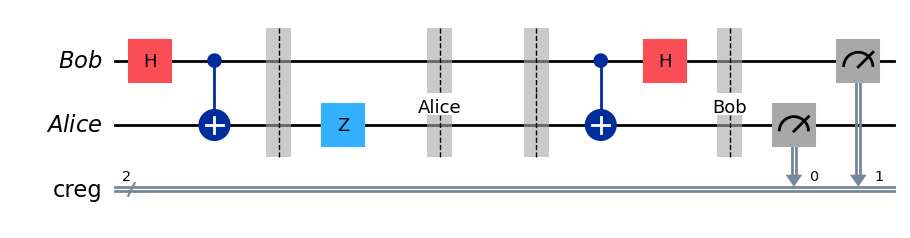

In [6]:

qc = prepare_phi1()### Charlie prepares the entagled state |Phi_+> and sends it to Alice and Bob
qc.barrier()


qc = alice_op(qc,'10')
qc.save_statevector(label = 'Alice')

qc.barrier()

qc.cx(1,0)
qc.h(1)

qc.save_statevector(label = 'Bob')

qc.measure([0,1],[0,1])
qc.draw('mpl', reverse_bits =True)

# Since this cannot be measured in the bell basis we need to manipulate
# it into such a way that it can be measured in the computational basis

In [7]:
res = simulator_aer.run(qc, shots = 1).result()


In [8]:
statevec_alice = res.data()['Alice']

statevec_bob = res.data()['Bob']

print(f"State after Alice's measurement:")
display(statevec_alice.draw(output = 'latex'))

print(f"State after Bob has manipulated the qubit")
display(statevec_bob.draw(output = 'latex'))

State after Alice's measurement:


<IPython.core.display.Latex object>

State after Bob has manipulated the qubit


<IPython.core.display.Latex object>

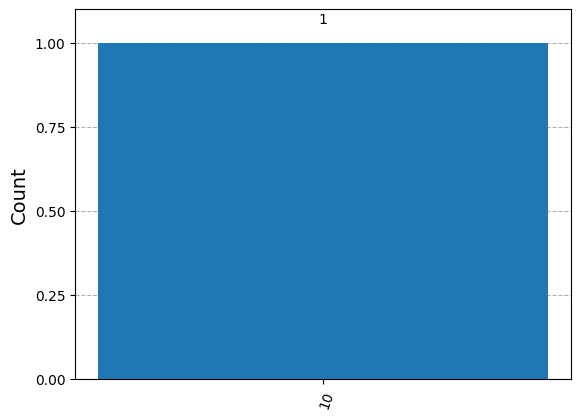

In [9]:
plot_histogram(res.get_counts())

### Eavesdropper:
Now let's investigate what happens if Eve intercepts Alice's qubit and makes a measurement:


If Eve intercepts Alice's qubit when she sends it to Bob, Eve will be able to measure her qubit and determine if it is in the state $|0\rangle$ or $|1\rangle$. If she has no access to Bob's qubit, however, she will be unable to determine anything about the entangled state the qubit was previously in, giving her no information about the 2 bits Alice was intending to send. This will also collapse Bob's qubit, which will be noticed upon measurement of both qubits and will alert him to an eavesdropper.

The following is an example to demonstrate the consequences of a measurement by Eve:

Suppose Alice has sent \( |\Phi_+\rangle \) and Eve measures this with the projector:
$$
E_0 = (|0\rangle\langle 0|_A \otimes I_B)  \\  
E_1 = (|1\rangle\langle 1|_A \otimes I_B) .
$$
Say Eve got the result which indicates Alice's qubit was \( |0\rangle \).  
We may describe the post-measurement state of the complete system using a density matrix formulation.  
The state before measurement was:

$$
\rho_{AB} = |\Phi_+\rangle\langle\Phi_+| = \frac{1}{2} \left( 
|0\rangle\langle 0|_A \otimes |0\rangle\langle 0|_B +
|0\rangle\langle 1|_A \otimes |0\rangle\langle 1|_B +
|1\rangle\langle 0|_A \otimes |1\rangle\langle 0|_B +
|1\rangle\langle 1|_A \otimes |1\rangle\langle 1|_B
\right)
$$

The post-measurement state is described by:

$$
\rho_{AB}' = \frac{E_i \rho_{AB} E_i}{p(i)}
$$

$$
p(i) = \text{Tr}(E_i \rho_{AB})
$$

If Eve measured $ |0\rangle $:

$$
\rho_{AB}' = |0\rangle\langle 0|_A \otimes |0\rangle\langle 0|_B
$$

It is quite clear that the state is no longer entangled, making it impossible to determine which two bits Alice intended to send.


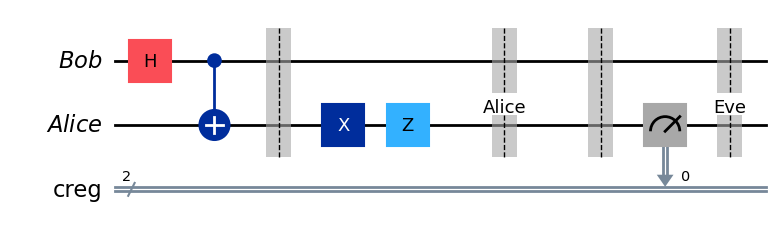

In [10]:

qc = prepare_phi1()### Charlie prepares the entagled state |Phi_+> and sends it to Alice and Bob
qc.barrier()


qc = alice_op(qc,'11')
qc.save_statevector(label = 'Alice')

qc.barrier()

### EVE:
qc.measure([0],[0])

qc.save_statevector(label = 'Eve')






qc.draw('mpl', reverse_bits =True)

# Since this cannot be measured in the bell basis we need to manipulate
# it into such a way that it can be measured in the computational basis

In [11]:
res_eve = simulator_aer.run(qc, shots = 1).result()

In [12]:
res_eve.get_counts()

{'00': 1}

Qiskit shows the state of both qubits, but in reality Eve can only measure one qubit so she only has the information about the qubit she measured. The other qubit will collapse to one of the two possible configurations, but Eve has no information about Bob's qubit so she will not know any of it. 

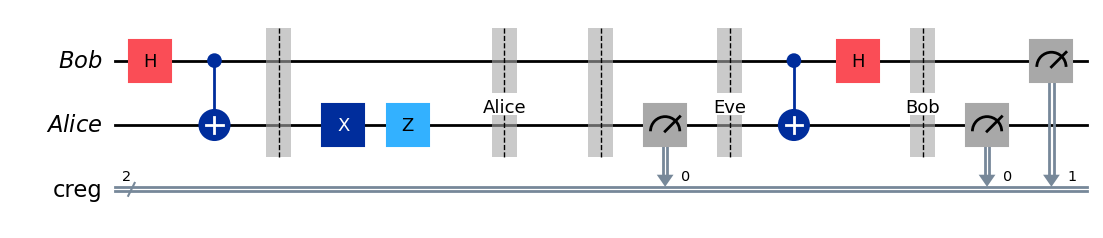

In [13]:

qc = prepare_phi1()### Charlie prepares the entagled state |Phi_+> and sends it to Alice and Bob
qc.barrier()


qc = alice_op(qc,'11')
qc.save_statevector(label = 'Alice')

qc.barrier()

### EVE:
qc.measure([0],[0])

qc.save_statevector(label = 'Eve')

qc.cx(1,0)
qc.h(1)
qc.save_statevector(label = 'Bob')
qc.measure([0,1],[0,1])




qc.draw('mpl', reverse_bits =True)

In [14]:
res_bob = simulator_aer.run(qc, shots = 1).result()

With Eve's measurement the qubit state has collapsed to:

In [15]:
statevec_alice = res_bob.data()['Alice']
statevec_eve = res_bob.data()['Eve']
statevec_bob = res_bob.data()['Bob']

print(f"State after Alice's measurement:")
display(statevec_alice.draw(output = 'latex'))
print(f"State after Eve's measurement:")
display(statevec_eve.draw(output = 'latex'))
print(f"State after Bob has manipulated the qubit")
display(statevec_bob.draw(output = 'latex'))

State after Alice's measurement:


<IPython.core.display.Latex object>

State after Eve's measurement:


<IPython.core.display.Latex object>

State after Bob has manipulated the qubit


<IPython.core.display.Latex object>

In [16]:
res_bob.get_counts()

{'11': 1}

Bob did not receive the correct bits.

## Exercise 6:
We must find projective measurements that let Alice and Bob determine what state their qubit is in. They know the two possibilities and they can only make local projective measurements.

$$
\text{State 1: } \frac{1}{\sqrt{2}} (|00\rangle + \,|11\rangle) \quad \text{and} \quad \text{State 2: } \frac{1}{\sqrt{2}} (|01\rangle + \,|10\rangle)
$$


In [48]:
def random_circuita():
    import random
    circ= []
    qc = QuantumCircuit(2)
    qc.h(0)
    qc.cx(0,1)
    circ.append(qc)
    qc1 = QuantumCircuit(2)
    qc1.x(1)
    qc1.h(0)
    qc1.cx(0,1)
    circ.append(qc1)
    return random.choice(circ)

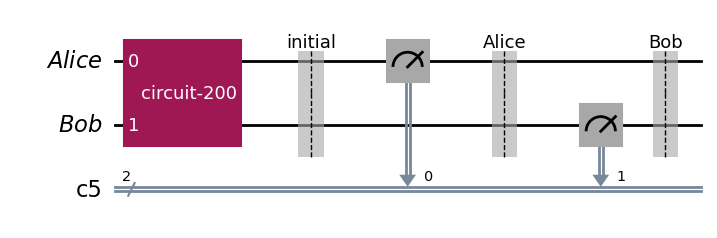

In [49]:
a = QuantumRegister(1, name = 'Alice')
b = QuantumRegister(1, name = 'Bob')
creg = ClassicalRegister(2)
qc = QuantumCircuit(a,b,creg)
circ = random_circuita()
qc.append(circ,[0,1])
qc.save_statevector(label = 'initial')
qc.measure([0],[0])
qc.save_statevector(label = 'Alice')
qc.measure([1],[1])
qc.save_statevector(label = 'Bob')
qc.draw('mpl')

In [50]:
result = simulator_aer.run(qc.decompose(), shots = 1).result()

In [51]:
alice_st = result.data()['Alice']
bob_st = result.data()['Bob']
initial_st =  result.data()['initial']


In [52]:
print("Alice's statevector is:")
alice_st.draw( output = 'latex')

Alice's statevector is:


<IPython.core.display.Latex object>

Even though qiskit shows us both qubits, let's pretend we only know hers. So we know that the state of her qubit was $|1\rangle$. Then Bob's qubit can be either $|1\rangle$ or $|0\rangle$

In [53]:
print("Bob's statevector is:")
bob_st.draw( output = 'latex')

Bob's statevector is:


<IPython.core.display.Latex object>

Since the state we found was $|1\rangle$ then we can determine that the initial state was State 1.

In [54]:
print("Initial statevector is:")
initial_st.draw( output = 'latex')

Initial statevector is:


<IPython.core.display.Latex object>

$$
\text{State 1: } \frac{1}{\sqrt{2}} (|00\rangle + \,|11\rangle) \quad \text{and} \quad \text{State 2: } \frac{1}{\sqrt{2}} (|00\rangle - \,|11\rangle)
$$
This can be a little bit trickier on qiskit since we cannot make measurements with basis that are not the computational one. Therefore what we must do is rewrite it so the X basis is interpreted in the computational basis. Essentially all we must do is apply the Hadamard on both qubits. Having done this we transform them back to distinct computational basis configurations and we can determine them.

$$
(H \otimes H)\frac{1}{\sqrt{2}} (|++\rangle + \,|--\rangle) = \frac{1}{\sqrt{2}} (|00\rangle + \,|11\rangle)
$$
$$
(H \otimes H)\frac{1}{\sqrt{2}} (|+-\rangle + \,|-+\rangle) =  \frac{1}{\sqrt{2}} (|01\rangle + \,|10\rangle)
$$

In [55]:
def random_circuitb():
    import random
    circ= []
    qc = QuantumCircuit(2)
    qc.h(0)
    qc.cx(0,1)
    circ.append(qc)
    qc1 = QuantumCircuit(2)
    qc1.x(0)
    qc1.h(0)
    qc1.cx(0,1)
    circ.append(qc1)
    return random.choice(circ)

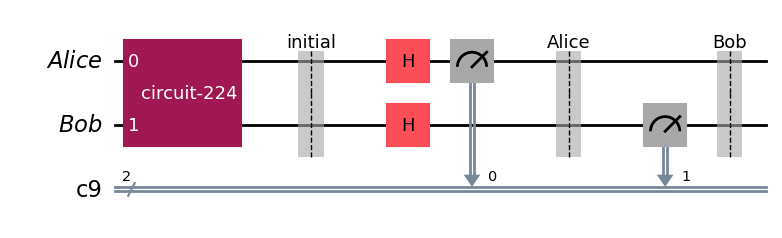

In [69]:
a = QuantumRegister(1, name = 'Alice')
b = QuantumRegister(1, name = 'Bob')
creg = ClassicalRegister(2)
qc = QuantumCircuit(a,b,creg)
circ = random_circuitb()
qc.append(circ,[0,1])
qc.save_statevector(label = 'initial')
qc.h(0)
qc.h(1)
qc.measure([0],[0])
qc.save_statevector(label = 'Alice')
qc.measure([1],[1])
qc.save_statevector(label = 'Bob')
qc.draw('mpl')

In [72]:
result = simulator_aer.run(qc.decompose(), shots = 1).result()
alice_st = result.data()['Alice']
bob_st = result.data()['Bob']
initial_st =  result.data()['initial']


In [73]:
print("Alice's statevector is:")
alice_st.draw( output = 'latex')

Alice's statevector is:


<IPython.core.display.Latex object>

Alice found $|0\rangle$. Therefore Bob's qubit can be $|0\rangle$ or $|1\rangle$. If it is the first we know it is state 1, if it is the latter we know that it was State 2

In [74]:
print("Bob's statevector is:")
bob_st.draw( output = 'latex')

Bob's statevector is:


<IPython.core.display.Latex object>

In [75]:
print("Initial statevector is:")
initial_st.draw( output = 'latex')

Initial statevector is:


<IPython.core.display.Latex object>

$$
\text{State 1: } \frac{1}{\sqrt{2}} (|00\rangle + i\,|11\rangle) \quad \text{and} \quad \text{State 2: } \frac{1}{\sqrt{2}} (|00\rangle - i\,|11\rangle)
$$
This case there is no possible basis we may choose to make this measurement directly. What we can do however is use Alice can use a S gate that if applied to one of this states will take them in the following manner:
$$
S(state1) =  \frac{1}{\sqrt{2}} (|00\rangle - \,|11\rangle) \\
S(state2) =  \frac{1}{\sqrt{2}} (|00\rangle +\,|11\rangle)
$$

So now we came back to the configuration used in letter (b). Then we can simply follow the same procedure and we will be able to determine the state.

In [88]:
def random_circuitc():
    import random
    circ= []
    qc = QuantumCircuit(2)
    qc.h(0)
    qc.cx(0,1)
    qc.s(0)
    circ.append(qc)
    qc1 = QuantumCircuit(2)
    qc1.x(0)
    qc1.h(0)
    qc1.cx(0,1)
    qc1.s(0)
    circ.append(qc1)
    return random.choice(circ)

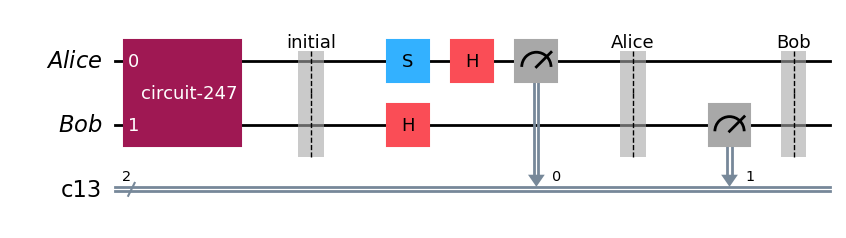

In [89]:
a = QuantumRegister(1, name = 'Alice')
b = QuantumRegister(1, name = 'Bob')
creg = ClassicalRegister(2)
qc = QuantumCircuit(a,b,creg)
circ = random_circuitc()
qc.append(circ,[0,1])
qc.save_statevector(label = 'initial')
qc.s(0)
qc.h(0)
qc.h(1)
qc.measure([0],[0])
qc.save_statevector(label = 'Alice')
qc.measure([1],[1])
qc.save_statevector(label = 'Bob')
qc.draw('mpl')

In [90]:
result = simulator_aer.run(qc.decompose(), shots = 1).result()
alice_st = result.data()['Alice']
bob_st = result.data()['Bob']
initial_st =  result.data()['initial']


In [91]:
print("Alice's statevector is:")
alice_st.draw( output = 'latex')

Alice's statevector is:


<IPython.core.display.Latex object>

Alice got $|0\rangle$. If Bob is found on $|0\rangle$ then it corresponds to $\frac{1}{\sqrt{2}} (|00\rangle + \,|11\rangle) $ which is state 2 before the S gate. 
If Bob is found on $|1\rangle$ then it corresponds to $\frac{1}{\sqrt{2}} (|00\rangle - \,|11\rangle) $ which is state 1 before the S gate. 

In [95]:
print("Bob's statevector is:")
bob_st.draw( output = 'latex')


Bob's statevector is:


<IPython.core.display.Latex object>

In [94]:
print("Initial statevector is:")
initial_st.draw( output = 'latex')

Initial statevector is:


<IPython.core.display.Latex object>